In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.polynomial.polynomial as poly

## Задача № 1

In [11]:
data = np.array([[70,  70, 96],
                 [80,  63, 75],
                 [90,  55, 74],
                 [100, 56, 65],
                 [110, 52, 63],
                 [120, 58, 72],
                 [130, 63, 75],
                 [140, 70, 80],
                 [150, 70, 89]])

Т.к. требуется, чтобы кривая проходила строго между точками Bid и Ask, построим точки, равные среднему между Bid и Ask, которые будем аппроксимировать полиномом

In [12]:
data = np.insert(data, 3, (data[:,1] + data[:,2])/2, axis=1)

In [13]:
x = data[:,0]
y = data[:,3]

Изобразим на графике точки Bid, Ask и среднее между ними

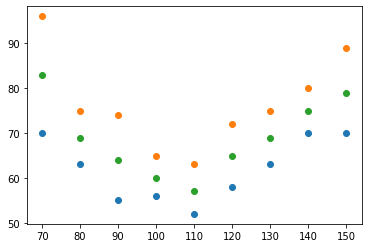

In [15]:
plt.scatter(x, data[:,1])
plt.scatter(x, data[:,2])
plt.scatter(x, data[:,3])



Напишем функцию для поиска оптимальной степени аппроксимирующего полинома следующим образом:
Введём функцию $\sigma_m = \frac{1}{n-m}\sqrt{\sum_1^n(P(x_i)-y_i)^2}$

Она тем меньше, чем меньше среднеквадратичное отклонение и тем больше, чем больше степень полинома, что позволяет избежать переобучения.

Так же напишем функцию для определения коэффициента детерминации.



In [48]:
def find_best_degree(x, y):
    sigmas = []
    for degree in range(1, x.shape[0]):
        coefs = poly.polyfit(x, y, degree)
        ffit = poly.polyval(x, coefs)
        sigmas.append(np.sqrt(np.sum((ffit-y)**2))/(x.shape[0] - degree))
    return sigmas
    
def calculate_r2(x, y, y_hat):
    SSres = np.sum((y-y_hat)**2)
    SStot = np.sum((y-np.mean(y))**2)
    
    return 1 - SSres/SStot

Посчитаем значения $\sigma_m$ для всех $m$ от 1 до 8.

In [49]:
find_best_degree(x, y)

[3.044419416462411,
 1.1124034655171346,
 0.6858413716341829,
 0.7648249897572902,
 0.9356284738213179,
 0.9299750883014447,
 1.2164375362665383,
 9.483412482263905e-08]

Как видим, минимальное значение $\sigma_m$ достигается при $m=8$. Тем не менее, это очень близко к количеству точек, что, вероятнее всего, означает переобучение.

Второе минимальное значение $\sigma_m$ достигается при $m=3$. Построим график, чтобы убедиться, что функция проходит строго между Bid и Ask и вычислим коэффициент детерминации

R^2 = 0.9716829064655149


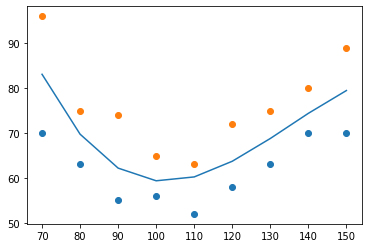

In [53]:
coefs = poly.polyfit(x, y, 3)
ffit = poly.polyval(x, coefs)

plt.scatter(x, data[:,1])
plt.scatter(x, data[:,2])
plt.plot(x, ffit)

print('R^2 =', calculate_r2(x, y, ffit))

## Задача №2
##### Наблюдение 1
Т.к. вращения рулетки независимы, то игра представляет собой марковскую цепь. Кроме того, наиболее подходящая математическая модель -- модель случайных блужданий
##### Наблюдение 2
Т.к. вращения рулетки независимы, то при существовании и единственности оптимальной стратегии оптимальная ставка может зависеть только от текущего размера банка

##### Наблюдение 3
Т.к. вероятности победы на каждом цвете одинаковы, то цвет, на который я ставлю не имеет значения. Игру можно заменить на нечестную монетку. Я выигрываю, если выпадает орёл($q = \frac{18}{37}$), казино выигрывает, если выпадает решка($p = \frac{19}{37}$)

### Эмпирическое решение

Кажется, что для того, чтобы увеличить банк на константную величину за $n$ ставок, нужно выиграть больше половины этих ставок.

Т.к. вероятность выигрыша меньше, чем $0.5$, то чем больше $n$, тем меньше вероятность выиграть больше половины ставок.

Таким образом, желательно увеличивать банк за минимальное число ставок, то есть размер ставок должен быть максимальным. Из этого следует, что на каждом шаге, нужно делать ставку в размере текущего банка. Но ситуация меняется, когда размер банка становится больше половины необходимой суммы. В таком случае рассмотрим следующее наблюдение.

##### Наблюдение 4

В случае, когда размер банка $b$ больше половины от необходимой для выигрыша суммы $a$, стоит ставить не $b$, а $a - b$, т.к. в таком случае мы не уменьшаем вероятность выиграть игру на текущем шаге, а в случае проигрыша ставки теряем меньше денег.

##### Итог эмпирического решения:
Оптимальна следующая стратегия: 

Пока размер банка $b$ меньше, чем половина необходимой для выигрыша суммы $a$ (в нашем случае $a = 10000$), стоит идти all-in, то есть делать ставки размера $r = b$. Если же $b \geq a/2 $, то стоит делать ставки размера $r = a-b $

### Строгое решение

##### Переформулируем задачу
Есть два игрока -- казино (первый игрок) и я (второй игрок). У меня в распоряжении 1000 рублей, у казино 9000. 

Пусть $A = -9000, B = 1000$. 

Для начала рассмотрим игру с постоянной единичной ставкой. Игрок выигрывает, если другой разоряется. 

Найдём вероятности победы первого и второго игрока через $n$ шагов. Каждый бросок нечестной монетки в таком случае можно рассматривать, как реализацию случайной величины $\xi_i$.

Если $\xi_i = +1$, то будем считать, что второй игрок платит один доллар первому, если $\xi_i = -1$, то наоборот.

Тогда $S_k = \xi_1 + \xi_2 + ... + \  \xi_k$ суть величина выигрыша первого игрока у второго на $k$-ом ходу.

В момент времени $k \leq n$, когда $S_k$ впервые становится равным $B$ или $A$, один из игроков разоряется, а его противник выигрывает.

##### Пусть: 

$x$ - целое число из $[A, B]$ 

$S_k^x = x + S_k$

$\tau_k^x$ = $min${$0\leq l \leq k: S_l^x = A$ или $B$} -- момент остановки

Если $A < S_K^x < B$ для всех $0 \leq l \leq k$, то $\tau_k^x = k$

##### Тогда:

Для всех $l<k$ множество $\{\omega: \tau_k^x = l\}$ это событие, означающее, что случайное блуждание $\{S_i^x, 0 \leq i \leq k\}$, начинающееся в начальный момент в точке x выйдет из интервала $(A, B)$ в момент $l$. 

Для $l\leq k$ множества $\{\omega: \tau_k^x = l, S_l^x = A\}$ и $\{\omega: \tau_k^x = l, S_l^x = B\}$ обозначают победу второго и первого игроков соответственно в момент $l$.

Для всех $0\leq k \leq n$:

$\mathcal{A}_k^x = \sum_{0\leq l \leq k} \{\omega: \tau_k^x = l, S_l^x = A\}$

$\mathcal{B}_k^x = \sum_{0\leq l \leq k} \{\omega: \tau_k^x = l, S_l^x = B\}$


Вероятности победы за время $[0, k]$ равны:

$\alpha_k(x) = P(\mathcal{A}_k^x)$  для второго игрока

$\beta_k(x) = P(\mathcal{B}_k^x)$  для первого игрока

##### Получим для этих вероятностей рекуррентные соотношения.

Пусть $A < x < B$ и $1\leq k \leq n$

Очевидно, $\alpha_0(x) = \beta_0(x) = 0$

По формуле полной вероятности:
$\beta_k(x) = P(\mathcal{B}_k^x) = P(\mathcal{B}_k^x|S_1^x = x+1)P\{\xi_1 = +1\} + P(\mathcal{B}_k^x|S_1^x = x-1)P\{\xi_1 = -1\}$ 

Очевидно, что $P(\mathcal{B}_k^x|S_1^x = x+1) = P(\mathcal{B}_{k-1}^{x+1})$, $P(\mathcal{B}_k^x|S_1^x = x-1) = P(\mathcal{B}_{k-1}^{x-1})$ (Просто считаем, что результат первого хода это начало игры)

Тогда 

$\beta_k(x) = p\beta_{k-1}(x+1) + q\beta_{k-1}(x-1)$

$\beta_l(B) = 1$, $\beta_l(A) = 0$ для $0\leq l\leq n$

Аналогично:

$\alpha_k(x) = p\alpha_{k-1}(x+1) + q\alpha_{k-1}(x-1)$

$\alpha_l(A) = 1$, $\alpha_l(B) = 0$ для $0\leq l\leq n$

Устремим $n$ к бесконечности:

Получим уравнение:

$\beta(x) = p\beta(x+1) + q\beta(x-1)$

С граничными условиями:

$\beta(B) = 1$, $\beta(A) = 0$ 

Очевидны два частных решения этого уравнения:

$\beta = a$

$\beta = b(q/p)^x$, где $a$ и $b$ константы

Тогда общее решение имеет вид:

$\beta = a + b(q/p)^x$

С учётом граничных условий получаем:

$\beta(x) = \frac{(q/p)^x - (q/p)^A}{(q/p)^B - (q/p)^A}$

$\beta = \frac{1 - (q/p)^A}{(q/p)^B - (q/p)^A}$

Аналогично

$\alpha(x) = \frac{(q/p)^B - (q/p)^x}{(q/p)^B - (q/p)^A}$

$\alpha = \frac{(q/p)^B - 1}{(q/p)^B - (q/p)^A}$


##### Рассмотрим случай понижения ставки

Пусть ставка теперь равна 1/2, а не 1

Предельная вероятность разорения второго игрока обозначим за $\beta_{1/2}$

Тогда $\beta_{1/2} = \frac{1 - (q/p)^{2A}}{(q/p)^{2B} - (q/p)^{2A}}$

или $\beta_{1/2} = \beta \cdot \frac{1 + (q/p)^A}{(q/p)^B + (q/p)^A} > \beta$ при $p>q$

Иными словами, т.к. вероятность повысилась несмотря на A и B, повышение ставки при игре в пользу казино повышает вероятность победы. 

На первом шаге максимизируем нашу ставку -- пойдём ва-банк

После этого, можно рассматривать получившуюся ситуацию как новую игру. Снова пойдём ва-банк и т.д.

Далее воспользуемся наблюдением 4, то есть будем идти ва-банк до тех пор, пока наш банк не превысит половину необходимой для победы суммы. Когда наша сумма будет больше половины, ставим сумму, недостоющую до 10000$. Итак, я аналитически доказал результат, полученный ранее эмпирически.


##### Ниже представлено дерево исходов оптимальной стратегии
<img src="Untitled 3.png">

Из дерева исходов можно найти вероятность уехать в лес под дулом пистолета.

Вероятность уехать в лес сразу после первой ставки равна $p$

Если мы выиграли первую ставку, то мы еще можем проиграть вторую(вероятность $pq$) и третью($pq^2$)

Даже если мы не проиграли на этом этапе, радоваться рано. Мы получаем бесконечную геометрическую прогрессию из-за возвращения к 2000 при проигрыше на 6000

Первый член прогрессии:
$p_0 = q^3p^3 + q^4p^3$

Знаменатель прогрессии:
$z = q^2p^2$

Сумма бесконечной геометрической прогрессии$p_{sum}$, как известно, равна
$p_{sum} = \frac{p_0}{1-z} = \frac{qp + q^2p}{1 - q^2p^2}$

Итого, вероятность пожалеть о своём решении брать в долг у опасных ребят равна $p_{res} = p + pq + pq^2 + \frac{q^3p^3 + q^4p^3}{1 - q^2p^2} \approx 0.92 $

## Задача № 3

In [92]:
btc_df = pd.read_csv('btc_historical.csv')

In [93]:
btc_df.drop(columns=['<TICKER>', '<PER>', '<TIME>', '<DATE>'], inplace=True)

Данные взяты с Finam.ru c 1/12/19 по 2/12/20 с дискретностью в один день. Я отбросил все ненужные стобцы

In [96]:
btc_df.isna().value_counts()

<CLOSE>
False      368
dtype: int64

Проверил, что в данных нет пропусков

In [97]:
btc_df.head(5)

,<CLOSE>
0,214.36
1,214.01
2,211.80
3,207.62
4,211.60


In [99]:
from hurst import compute_Hc

In [141]:
H, c, val = compute_Hc(btc_df['<CLOSE>'])

In [143]:
print('Показатель Хёрста:', H)

Показатель Хёрста: 0.5101254240100435


Напишем функцию для рассчёта относительного процентного приращения за определённый период, исходя из следующего определения:

Относительное приращение функции $f(x)$ равно $ \frac{\Delta f}{\Delta x}$

Относительное процентное приращение: $f(x)$ равно $\frac{\Delta f}{f(x_0)\Delta x}$

В нашем случае имеем функцию цены от времени.





In [193]:
def calculate_increase(row, period ):
    if int(row.name) >= period:
        return (row['<CLOSE>'] / btc_df['<CLOSE>'].iloc[int(row.name) - period] - 1)/period

Создадим датасеты 'btc_daily_increase' и 'btc_weekly_increase', в которых будут содержаться относительные процентные приращения с периодом в день и неделю соответственно

Домножим на 100 элементы каждого датасета, чтобы там хранились единицы процентов

In [282]:
btc_daily_increase = btc_df.apply(calculate_increase, args=[1], axis=1)
btc_weekly_increase = btc_df.apply(calculate_increase, args=[7], axis=1)

btc_daily_increase *= 100
btc_weekly_increase *= 100


In [283]:
btc_daily_increase.dropna(inplace=True)
btc_weekly_increase.dropna(inplace=True)


In [284]:
print('Относительное процентное приращения с периодом в день за первые 5 дней, для которых оно определено: ')
print(btc_daily_increase.head(5))
print('Относительное процентное приращения с периодом в неделю за первые 5 дней, для которых оно определено: ')
print(btc_weekly_increase.head(5))

Относительное процентное приращения с периодом в день за первые 5 дней, для которых оно определено: 
1   -0.163277
2   -1.032662
3   -1.973560
4    1.916964
5    0.775047
dtype: float64
Относительное процентное приращения с периодом в неделю за первые 5 дней, для которых оно определено: 
7    -0.109962
8    -0.375149
9    -0.337245
10   -0.063302
11   -0.353092
dtype: float64


Напишем функцию для рассчета n-того центрального момента

In [285]:
def calculate_nth_center_moment(x, n):
    return ((x - x.mean())**n).mean()

In [286]:
daily_1st_central = calculate_nth_center_moment(btc_daily_increase, 1)
daily_2nd_central = calculate_nth_center_moment(btc_daily_increase, 2)
daily_3rd_central = calculate_nth_center_moment(btc_daily_increase, 3)

print(f'Период в день. Первый ц.м.: {daily_1st_central}, второй ц.м.: {daily_2nd_central}, третий ц.м.: {daily_3rd_central}')

weekly_1st_central = calculate_nth_center_moment(btc_weekly_increase, 1)
weekly_2nd_central = calculate_nth_center_moment(btc_weekly_increase, 2)
weekly_3rd_central = calculate_nth_center_moment(btc_weekly_increase, 3)

print(f'Период в неделю. Первый ц.м.: {weekly_1st_central}, второй ц.м.: {weekly_2nd_central}, третий ц.м.: {weekly_3rd_central}')


Период в день. Первый ц.м.: 3.872167497330246e-17, второй ц.м.: 30.263209435479315, третий ц.м.: -119.11186762036483
Период в неделю. Первый ц.м.: -1.4761968194461916e-17, второй ц.м.: 3.34910876039672, третий ц.м.: -0.6821430303071647


Напишем функцию для несмещенной и состоятельной оценки среднего и дисперсии нормального распределения по выборке x

In [287]:
def fit_gaussian(x):
    return x.mean(), ((x - x.mean())**2).sum()/(x.shape[0]-1)

In [288]:
daily_gaussian = fit_gaussian(btc_daily_increase)
weekly_gaussian = fit_gaussian(btc_weekly_increase)

In [289]:
print(f'Оценка параметров нормального распределения по выборке с периодом в день. Матожидание: {daily_gaussian[0]}, дисперсия:{daily_gaussian[1]}')
print(f'Оценка параметров нормального распределения по выборке с периодом в неделю. Матожидание: {weekly_gaussian[0]}, дисперсия:{weekly_gaussian[1]}')

Оценка параметров нормального распределения по выборке с периодом в день. Матожидание: 0.24708221623502863, дисперсия:30.34589580005713
Оценка параметров нормального распределения по выборке с периодом в неделю. Матожидание: 0.20581747821810772, дисперсия:3.358411840286711


In [290]:

import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt


/home/drone/enviroments/jupyter_env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


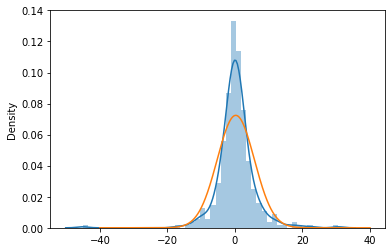

In [293]:
x = np.linspace(-40,40,1000)
y = norm.pdf(x, loc=daily_gaussian[0], scale=daily_gaussian[1]**0.5)

ax = sns.distplot(btc_daily_increase)
plt.plot(x, y)

/home/drone/enviroments/jupyter_env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


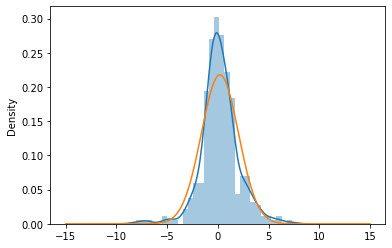

In [296]:
x = np.linspace(-15,15,5000)
y = norm.pdf(x, loc=weekly_gaussian[0], scale=weekly_gaussian[1]**0.5)

ax = sns.distplot(btc_weekly_increase)
plt.plot(x, y)

Главеое отличие -- коэффициент эксцесса. У аппроксимирующей кривой в обоих случаях он положителен, а у нормального распределения он равен нулю.

In [299]:
btc_daily_increase_df = pd.DataFrame(btc_daily_increase)
btc_weekly_increase_df = pd.DataFrame(btc_weekly_increase)

In [304]:
btc_daily_increase_df['MSTD'] = btc_daily_increase_df.rolling(30).std()
btc_weekly_increase_df['MSTD'] = btc_weekly_increase_df.rolling(30).std()

In [309]:
print('Медиана STD на скользящем окне 30 дней с периодом в день:',btc_daily_increase_df['MSTD'].dropna().median())
print('Медиана STD на скользящем окне 30 дней с периодом в неделю:',btc_weekly_increase_df['MSTD'].dropna().median())

Медиана STD на скользящем окне 30 дней с периодом в день: 4.198724348460576
Медиана STD на скользящем окне 30 дней с периодом в неделю: 1.1979969063887652
